# __This is the experimentation notebook for examine and building the model that navigates to it's target shape..__

In [20]:
# Importing the libraries and modules for this task
import os
import json
import torch
import torch.nn as nn  
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Checking for the GPU support (CUDA)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


>> So we the NVIDIA Cuda GPU for training the models..

In [21]:
 # We have the fixed words for our data, so I am making a custom vocabulary

VOCAB = {
    "go": 0, "to": 1, "the": 2,
    "red": 3, "green": 4, "blue": 5,
    "circle": 6, "square": 7, "triangle": 8
}

PAD_IDX = 9
VOCAB_SIZE = 10
MAX_LEN = 5

RGB


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

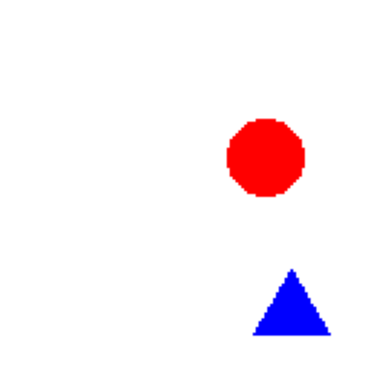

In [22]:
# checking the image data for further modelling
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("assignment_dataset/data/images/000000.png")
print(img.mode)   # should print 'RGB'

plt.imshow(img)
plt.axis("off")

In [23]:
class NavigationDataset(Dataset):
    def __init__(self, root):
        self.img_dir = os.path.join(root, "images")
        self.ann_dir = os.path.join(root, "annotations")

        self.files = sorted([
            f for f in os.listdir(self.img_dir) if f.endswith(".png")
        ])

        self.transform = T.ToTensor()

    def tokenize(self, text):
        """
        Converts text instruction to fixed-length token IDs
        """
        tokens = text.lower().replace(",", "").split()
        ids = [VOCAB.get(tok, PAD_IDX) for tok in tokens]
        ids = ids[:MAX_LEN] + [PAD_IDX] * (MAX_LEN - len(ids))
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        
        img_name = self.files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)  # (3, 128, 128)

        
        ann_path = os.path.join(
            self.ann_dir,
            img_name.replace(".png", ".json")
        )
        ann = json.load(open(ann_path))

       
        text_ids = self.tokenize(ann["text"])

        
        path = torch.tensor(
            ann["path"],
            dtype=torch.float32
        ) / 128.0  

        return img, text_ids, path

    def __len__(self):
        return len(self.files)

In [ ]:
# Making our dataset using the upper Navigator Class
dataset = NavigationDataset("assignment_dataset/data")
img, text, path = dataset[0]

print("Image Tensor Shape: ", img.shape)
print("Text Tensor Shape: ", text.shape)
print("Path Shape: ", path.shape)

Image Tensor Shape:  torch.Size([3, 128, 128])
Text Tensor Shape:  torch.Size([5])
Path Shape:  torch.Size([10, 2])


In [19]:
print(len(dataset))

1000


In [20]:
# Using the dataset -> Dataloader for tarining the data into batches for smooth training and low load on GPU
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

batch = next(iter(loader))
print([x.shape for x in batch])

[torch.Size([32, 3, 128, 128]), torch.Size([32, 5]), torch.Size([32, 10, 2])]


In [24]:
# Building the custom transformer model for smooth training..

class MultiModalTransformer(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN Vision Encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.img_proj = nn.Linear(64 * 32 * 32, 256)

        # Text Encoder
        self.text_emb = nn.Embedding(VOCAB_SIZE, 256)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=4
        )

        # Decoder → 10 × (x, y)
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 20)
        )

    def forward(self, img, text):
        img_feat = self.cnn(img)
        img_token = self.img_proj(img_feat).unsqueeze(1)

        text_tokens = self.text_emb(text)

        fused = torch.cat([img_token, text_tokens], dim=1)
        fused = self.transformer(fused)

        out = self.decoder(fused[:, 0])
        return out.view(-1, 10, 2)

> Let's test the upper model

In [22]:
print(device)

cuda


In [ ]:
model = MultiModalTransformer().to(device)

img_b, text_b, path_b = next(iter(loader))
img_b = img_b.to(device)
text_b = text_b.to(device)

with torch.no_grad():
    pred = model(img_b, text_b)

print("Prediction:", pred.shape)

Prediction: torch.Size([32, 10, 2])


> So we got an test ouput for our query image

## Setting up the training environment

In [27]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# loss function
loss_fn = nn.MSELoss()

In [28]:
EPOCHS = 40
losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for img, text, path in loader:
        img = img.to(device)
        text = text.to(device)
        path = path.to(device)

        pred = model(img, text)
        loss = loss_fn(pred, path)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {avg_loss:.4f}")


Epoch 1/40 — Loss: 0.0442
Epoch 2/40 — Loss: 0.0200
Epoch 3/40 — Loss: 0.0193
Epoch 4/40 — Loss: 0.0192
Epoch 5/40 — Loss: 0.0186
Epoch 6/40 — Loss: 0.0162
Epoch 7/40 — Loss: 0.0139
Epoch 8/40 — Loss: 0.0132
Epoch 9/40 — Loss: 0.0107
Epoch 10/40 — Loss: 0.0086
Epoch 11/40 — Loss: 0.0059
Epoch 12/40 — Loss: 0.0044
Epoch 13/40 — Loss: 0.0035
Epoch 14/40 — Loss: 0.0030
Epoch 15/40 — Loss: 0.0028
Epoch 16/40 — Loss: 0.0025
Epoch 17/40 — Loss: 0.0025
Epoch 18/40 — Loss: 0.0025
Epoch 19/40 — Loss: 0.0022
Epoch 20/40 — Loss: 0.0021
Epoch 21/40 — Loss: 0.0019
Epoch 22/40 — Loss: 0.0019
Epoch 23/40 — Loss: 0.0020
Epoch 24/40 — Loss: 0.0018
Epoch 25/40 — Loss: 0.0018
Epoch 26/40 — Loss: 0.0016
Epoch 27/40 — Loss: 0.0016
Epoch 28/40 — Loss: 0.0016
Epoch 29/40 — Loss: 0.0017
Epoch 30/40 — Loss: 0.0015
Epoch 31/40 — Loss: 0.0015
Epoch 32/40 — Loss: 0.0015
Epoch 33/40 — Loss: 0.0015
Epoch 34/40 — Loss: 0.0015
Epoch 35/40 — Loss: 0.0014
Epoch 36/40 — Loss: 0.0015
Epoch 37/40 — Loss: 0.0014
Epoch 38/4

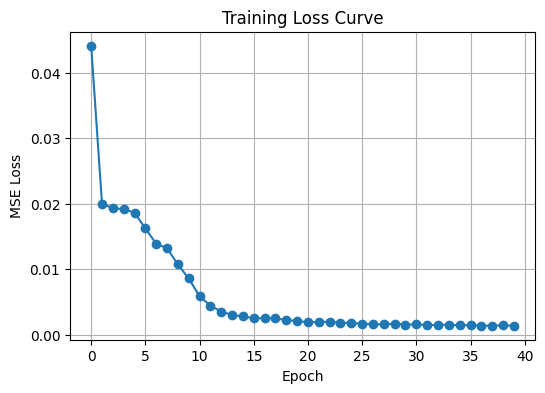

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

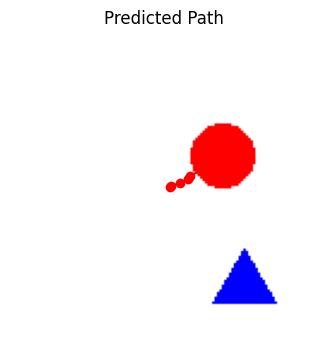

In [30]:
model.eval()

img, text, path = dataset[0]
img_t = img.unsqueeze(0).to(device)
text_t = text.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img_t, text_t)[0].cpu().numpy() * 128

img_np = img.permute(1,2,0).numpy()

plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.plot(pred[:,0], pred[:,1], "ro-")
plt.title("Predicted Path")
plt.axis("off")
plt.show()

In [ ]:
# saving the trained model 
torch.save(model.state_dict(), "multimodel_transfomer.pth")

### __After saving the model, just load the model below for testing..__

In [6]:
model = MultiModalTransformer().to(device)
model.load_state_dict(
    torch.load("multimodel_transfomer.pth", map_location=device)
)
model.eval()

MultiModalTransformer(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (img_proj): Linear(in_features=65536, out_features=256, bias=True)
  (text_emb): Embedding(10, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1,

In [7]:
def tokenize_text(text):
    tokens = text.lower().replace(",", "").split()
    ids = [VOCAB.get(tok, PAD_IDX) for tok in tokens]
    ids = ids[:MAX_LEN] + [PAD_IDX] * (MAX_LEN - len(ids))
    return torch.tensor(ids, dtype=torch.long).unsqueeze(0)


In [8]:
def predict_path(image_path, text):
    # Load image
    img = Image.open(image_path).convert("RGB")
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)

    # Tokenize text
    text_tensor = tokenize_text(text).to(device)

    # Predict
    with torch.no_grad():
        pred = model(img_tensor, text_tensor)[0]

    # Denormalize coordinates
    path = (pred.cpu().numpy() * 128).tolist()

    return img, path

In [16]:
import os
print(os.getcwd())

/home/rikin/personal-projects/the-neural-navigator


In [18]:
os.path.exists("assignment_dataset/test_data/images")

True

In [17]:
image_path = os.path.join("assignment_dataset", "test_data", "images", "000057.png")
text_command = "Go to the Blue Triangle"

img, path = predict_path(image_path, text_command)

print("Predicted Path:")
for p in path:
    print(p)

Predicted Path:
[65.99165344238281, 62.44663619995117]
[68.64383697509766, 68.35366821289062]
[72.8174057006836, 75.32784271240234]
[76.58184814453125, 79.70527648925781]
[80.66136169433594, 83.7752685546875]
[84.51715087890625, 90.49072265625]
[87.38680267333984, 93.72972106933594]
[91.59613037109375, 97.70245361328125]
[98.4242935180664, 102.60196685791016]
[100.4847640991211, 106.26551818847656]


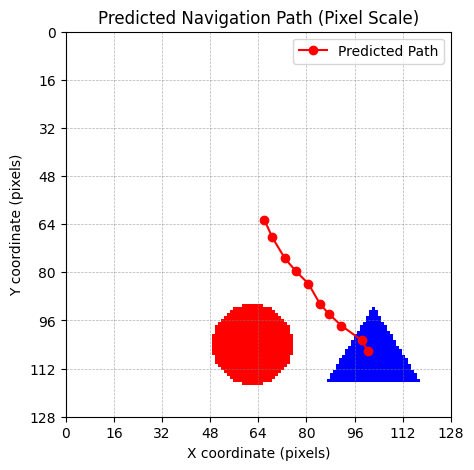

In [18]:
# Visualization of path

import numpy as np
path_np = np.array(path)  # (10, 2)

plt.figure(figsize=(5, 5))
plt.imshow(img)

# Plot predicted path
plt.plot(path_np[:, 0], path_np[:, 1], "ro-", label="Predicted Path")

# ---- Axis scaling ----
plt.xlim(0, 128)
plt.ylim(128, 0)  # invert Y-axis to match image coords

# ---- Ticks ----
plt.xticks(range(0, 129, 16))
plt.yticks(range(0, 129, 16))

# ---- Grid ----
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.6)

# ---- Labels ----
plt.xlabel("X coordinate (pixels)")
plt.ylabel("Y coordinate (pixels)")
plt.title("Predicted Navigation Path (Pixel Scale)")
plt.legend()

plt.show()